In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pingouin as pg
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import zscore, shapiro, kstest
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import joblib


In [132]:
df_salario = pd.read_csv('./datasets/dataset_salarios.csv')

In [133]:
# gerar uma copia do dataFrame para EDA e Bucketing
df_salario_eda = df_salario.copy()
df_salario_bucketing = df_salario.copy()

In [134]:
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


### EDA

In [135]:
df_salario_eda.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [136]:
# verificar dados ausentes
df_salario_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [137]:
df_salario_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

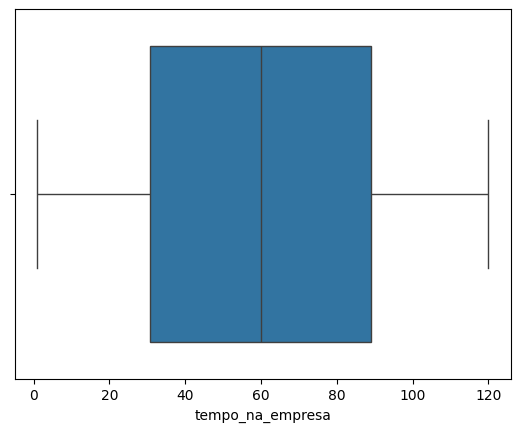

In [138]:
# verificar/detectar outliers
sns.boxplot(data=df_salario_eda, x='tempo_na_empresa')

<Axes: xlabel='nivel_na_empresa'>

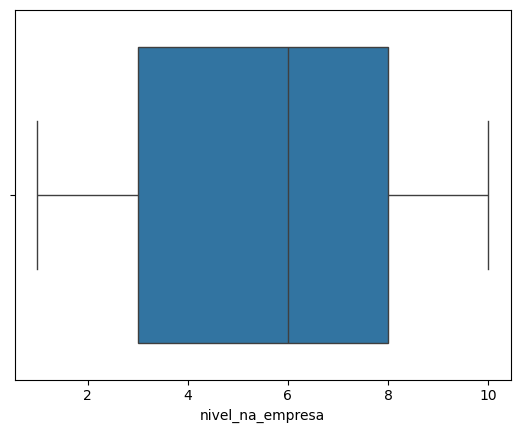

In [139]:
sns.boxplot(data=df_salario_eda, x='nivel_na_empresa')

<Axes: xlabel='salario_em_reais'>

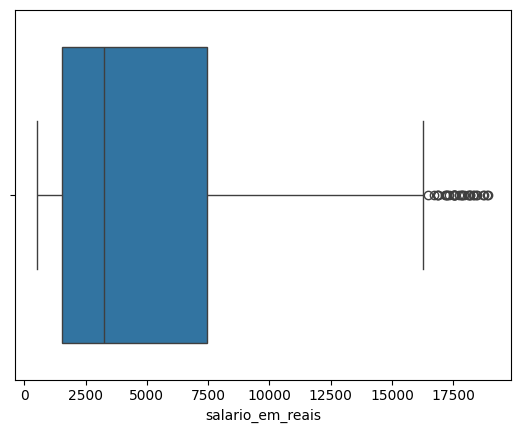

In [140]:
sns.boxplot(data=df_salario_eda, x='salario_em_reais')

<Figure size 1000x600 with 0 Axes>

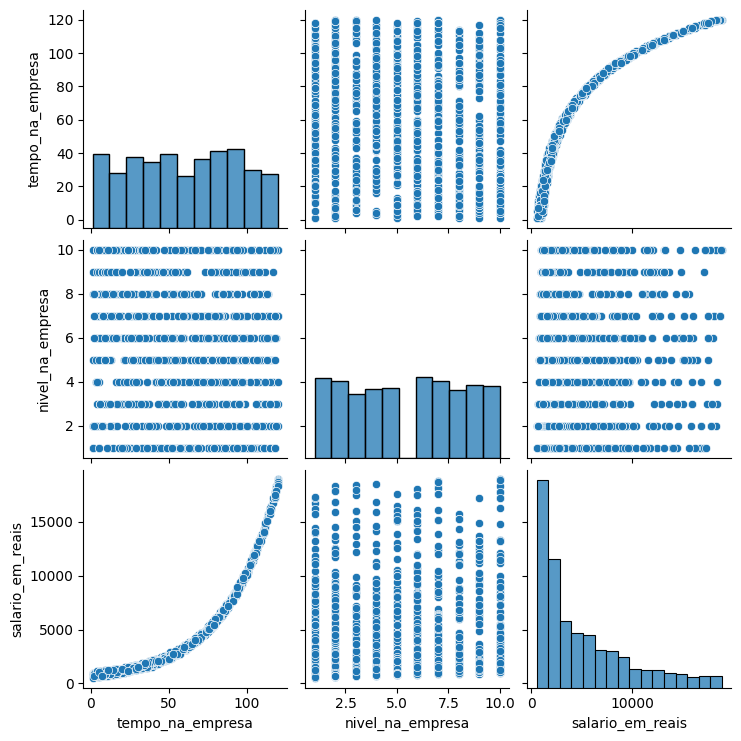

In [141]:
# cruzamento entre variaveis com salario_em_reais
plt.figure(figsize=(10,6))
sns.pairplot(df_salario_eda)

<Axes: >

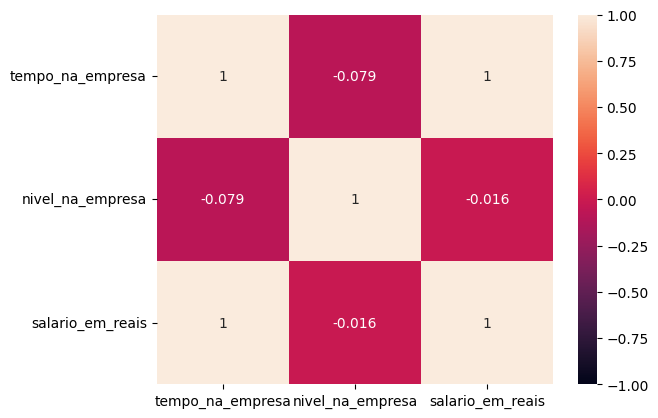

In [142]:
# mapa de calor (correlação entre as variaveis)
sns.heatmap(df_salario_eda.corr('spearman'), vmin=-1, vmax=1, annot=True)

<Axes: >

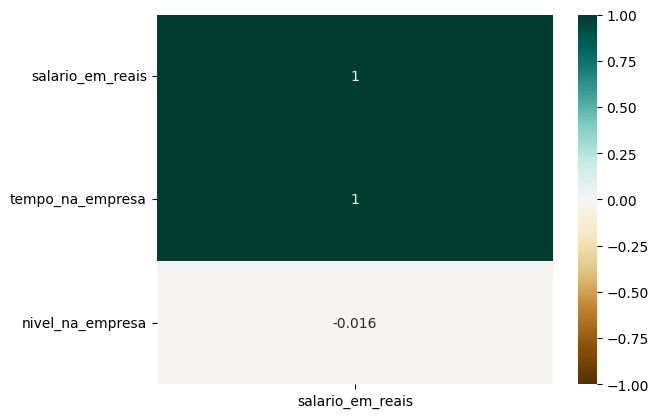

In [143]:
# mapa de calor em formato de ranking
sns.heatmap(df_salario_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [144]:
# Bucketing tempo de casa
bins_tempo_casa = [0, 10, 20, 30, 40, 50, 60, 70 ,80 ,90, 100, 110, 120, 130]
labels_tempo_casa = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129']

df_salario_bucketing['escala_tempo'] = pd.cut(x=df_salario_bucketing['tempo_na_empresa'], bins=bins_tempo_casa, labels=labels_tempo_casa, include_lowest=True)

In [145]:
df_salario_bucketing.head(20)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais,escala_tempo
0,50,1,2288.13,40-49
1,49,4,2389.84,40-49
2,39,10,2158.73,30-39
3,51,1,2341.06,50-59
4,62,7,3584.20,60-69
5,105,10,12102.18,100-109
6,80,3,5723.35,70-79
7,85,2,6424.92,80-89
8,66,5,3916.18,60-69
9,73,5,4751.79,70-79


<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

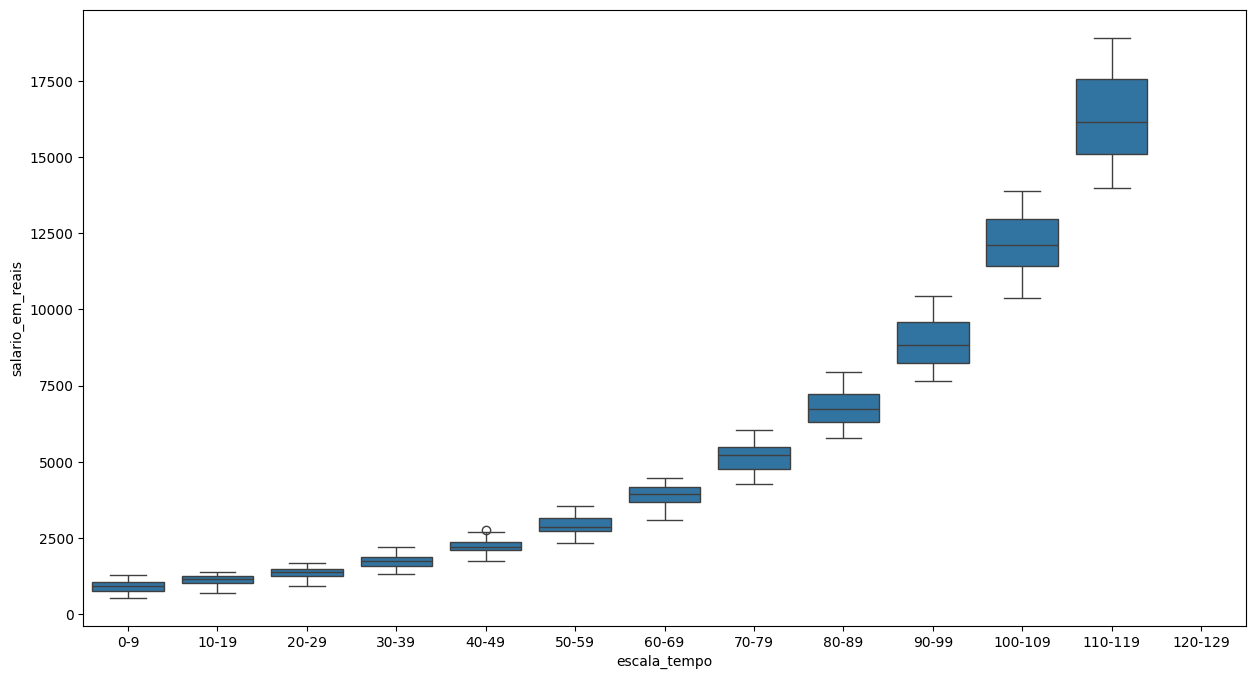

In [146]:
plt.figure(figsize=(15,8))
sns.boxplot(df_salario_bucketing, x='escala_tempo', y='salario_em_reais')

### Treinamento do Modelo - Linear

In [147]:
# Criae o dataset de treino de teste
X = df_salario.drop(columns='salario_em_reais', axis=1)
y = df_salario['salario_em_reais']

In [148]:
# split com k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [149]:
kf

KFold(n_splits=5, random_state=51, shuffle=True)

In [150]:
print(type(X))
print(type(y))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [151]:
# Bloco de treinamento do modelo

# Pipeline
# Padronizar variaveis numéricas - nivel_na_empresa, tempo_na_empresa

# Nome das colunas
colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformer para colunas numericas
transformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Criar ColunsTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ]
)

# Criar modelo com o Pipeline principal = Pré-Processamento + Treinamento
model_regr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Armazenar RMSE de treinamento e teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R2 Score de teste
r2score_fold_test = []

# Aramazenar Resíduos
residuos = []

# Amazenar predições
y_pred_total = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # treine o modelo no conjunto de treinamento
    model_regr.fit(X_train, y_train)

    # Faça predições nos conjuntos de treino e teste
    y_train_pred = model_regr.predict(X_train)
    y_test_pred = model_regr.predict(X_test)

    # Calcule o RMSE para os conjuntos de treino e teste
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Calcule o R2 Score para o conjunto de teste
    r2score_test = r2_score(y_test, y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)

    # Armazeno as métricas de iteração na lista
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    r2score_fold_test.append(r2score_test)
    residuos.append(residuos_test)

    y_pred_total.append(y_test_pred)

rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2score_test_final = np.mean(r2score_fold_test)
percentual_rmse_final = (rmse_test_final - rmse_train_final) / rmse_train_final
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

### Análise de Métricas - Modelo Linear

In [152]:
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'% dif. RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2score_test_final}')

RMSE Treino: 1882.8318426651392
RMSE Teste: 1886.4504221336076
% dif. RMSE Treino e Teste: 0.0019218813844503052
R2Score Teste: 0.8261178870584761


### Análise de Resíduos - Modelo Linear

In [153]:
# Transformar resíduos na escala padrãp
# (X - Média) / Desvio Padrão
residuos_std = zscore(residuos)

In [154]:
residuos_std

array([ 5.95616525e-01, -7.24916727e-01, -6.46846433e-01,  8.64095533e-01,
       -5.33806156e-02, -7.61704833e-01,  6.80947606e-01,  1.45661295e+00,
        3.15407488e-01, -5.85616590e-01,  1.29483240e-01,  8.62850152e-01,
       -8.81408422e-01, -2.57676835e-01, -3.98447700e-01,  4.84215194e-01,
       -9.30147928e-01, -1.98427398e-01,  2.09007896e-01, -9.04965560e-01,
       -6.81287606e-02, -8.34446292e-01, -3.95656924e-01,  1.85180868e-01,
       -8.59767063e-01, -1.16014546e+00, -9.89137623e-01,  1.98282340e+00,
       -7.09136535e-01, -5.86755306e-01,  2.97904569e+00,  3.41834809e-01,
       -1.07716414e+00,  1.30248304e+00, -5.99662310e-01, -4.35883427e-01,
       -5.78726106e-01, -1.02611646e+00,  3.62850210e-01,  1.01353539e+00,
       -3.51902591e-01,  9.50243614e-01,  1.10020428e+00,  3.93453210e-01,
       -8.28856918e-02, -2.86114598e-01, -1.14814701e+00, -7.64435745e-01,
       -2.96268121e-01, -9.37004031e-01, -5.80106334e-01,  4.60575328e-02,
       -2.64983022e-01,  

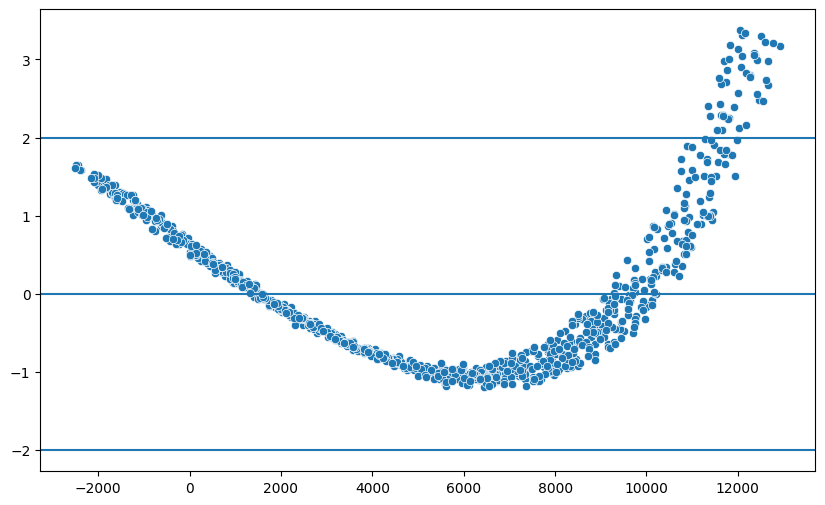

In [155]:
# Verificar linearidade dos resíduos: Valores entre -2 e +2 (escala padrão)
# Verificar a homocedasticidade: Valores em torno da reta sem nenhuma tendencia ou formato
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

Text(0, 0.5, 'Resíduos na escala padrão')

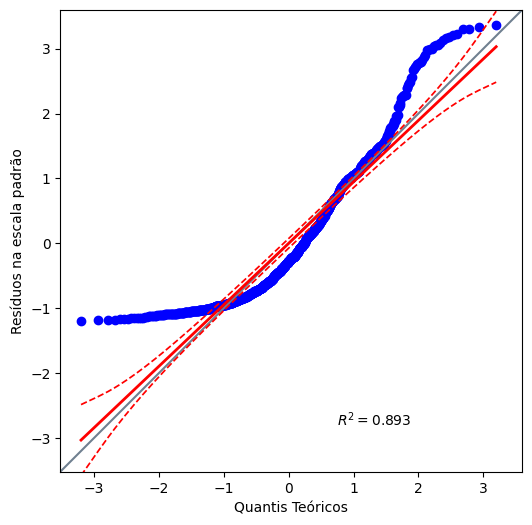

In [156]:
# Checar se resíduos seguem uma distribuição normal
# QQ-Plot
plt.figure(figsize=(10,6))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')

In [157]:
# Teste de normalidade - Shapiro-Wilk
stats_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estat. Teste: {stats_shapiro} e P-value: {p_value_shapiro}') 

Estat. Teste: 0.891969217965228 e P-value: 7.013497918013492e-26


In [158]:
# Teste de normalidade - Kolmogorov-Smirnov
stats_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estat. Teste: {stats_ks} e P-value: {p_value_ks}') 

Estat. Teste: 0.5939999999999955 e P-value: 0.0


In [159]:
# Teste de normalidade - Lilliefors
stats_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estat. Teste: {stats_ll} e P-value: {p_value_ll}') 

Estat. Teste: 0.11825983774680088 e P-value: 0.0009999999999998899


### Treinar Modelo - Polinomial

In [160]:
# Exemplo de criação de features polinomiais
feat_poly = PolynomialFeatures(degree=3, include_bias=True)
X_poly = feat_poly.fit_transform(X)
feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [161]:
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['1', 'tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [162]:
# Bloco de treinamento do modelo

graus_polymonial = [4]

rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

# split com k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polymonial:

    # Pipeline
    # Padronizar variaveis numéricas - nivel_na_empresa, tempo_na_empresa

    # Nome das colunas
    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

    # Transformer para colunas numericas
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Criar ColunsTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )

    # Criar features polinomiais
    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    # Criar modelo com o Pipeline principal = Pré-Processamento + Treinamento
    model_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', poly_feat),
        ('regressor', LinearRegression())
    ])

    # Armazenar RMSE de treinamento e teste
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar R2 Score de teste
    r2score_fold_test = []

    # Aramazenar Resíduos
    residuos = []

    # Amazenar predições
    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # treine o modelo no conjunto de treinamento
        model_poly.fit(X_train, y_train)

        # Faça predições nos conjuntos de treino e teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)

        # Calcule o RMSE para os conjuntos de treino e teste
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Calcule o R2 Score para o conjunto de teste
        r2score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)

        # Armazeno as métricas de iteração na lista
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)

        y_pred_total.append(y_test_pred)

    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2score_test_final = np.mean(r2score_fold_test)
    percentual_rmse_final = (rmse_test_final - rmse_train_final) / rmse_train_final
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    percentual_rmse_values.append(percentual_rmse_final)
    r2score_test_values.append(r2score_test_final)



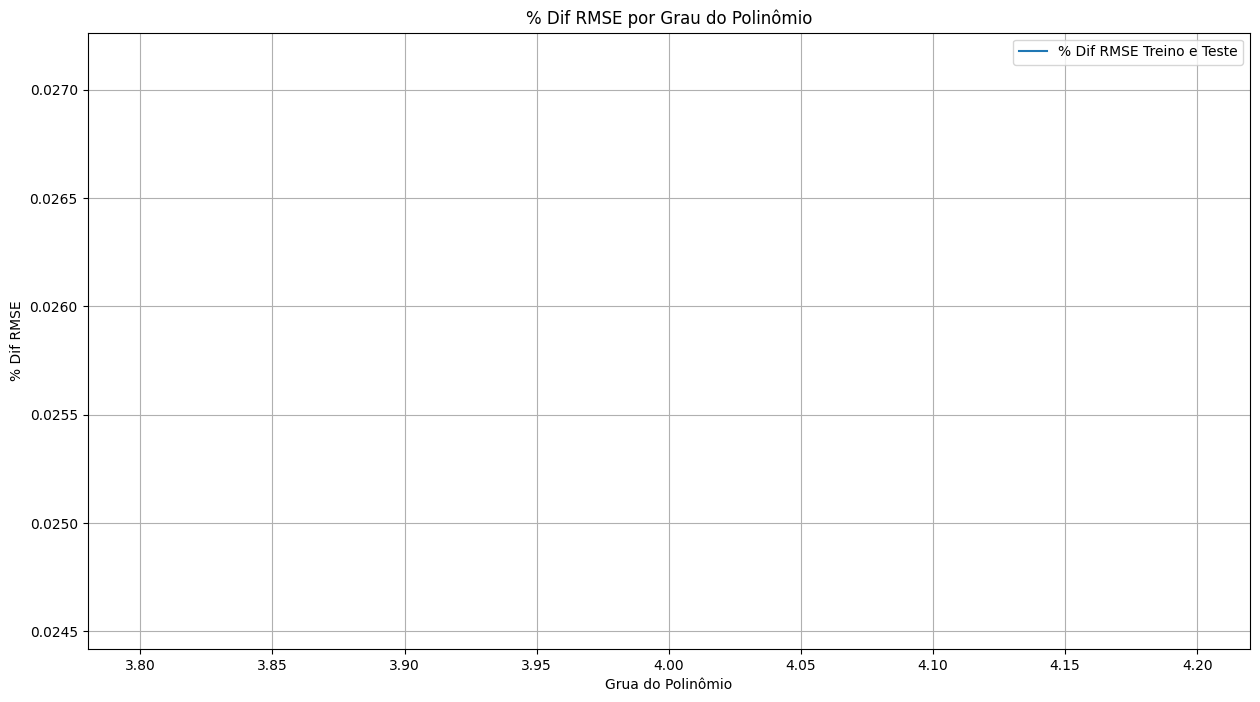

In [163]:
# Criar um plot para comparação gráfica de RMSE por grau de polinômio
plt.figure(figsize=(15,8))
plt.plot(graus_polymonial, percentual_rmse_values, label='% Dif RMSE Treino e Teste')
plt.xlabel('Grua do Polinômio')
plt.ylabel('% Dif RMSE')
plt.title('% Dif RMSE por Grau do Polinômio')
plt.legend()
plt.grid(True)
plt.show()

### Análise de Métricas - Modelo Polinomial

In [164]:
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'% dif. RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2score_test_final}')

RMSE Treino: 53.32698559565161
RMSE Teste: 54.70504352796304
% dif. RMSE Treino e Teste: 0.025841661907546578
R2Score Teste: 0.9998524123039415


### Análise de Resíduos - Modelo Linear

In [165]:
# Transformar resíduos na escala padrãp
# (X - Média) / Desvio Padrão
residuos_std = zscore(residuos)

In [166]:
residuos_std

array([-1.76658136e+00,  6.13919903e-01,  4.57932407e-01,  3.77621549e-01,
       -1.77161928e+00, -2.13372467e+00, -2.88053498e-01, -1.15486201e+00,
        1.26076256e+00, -1.38932876e+00, -1.63659072e-01,  9.49916278e-01,
        1.10428797e+00, -1.69277005e+00, -1.55137077e+00,  6.50212053e-01,
        2.39650670e+00, -5.48674224e-01, -4.71815369e-01, -4.93214903e-01,
       -9.93275437e-01,  4.37069649e-01, -2.35827600e-01,  4.45720599e-01,
        1.40041227e-01, -2.28929917e+00,  3.58302195e-01,  6.15006495e-01,
        1.42514234e+00, -1.40851950e+00,  1.28177409e+00, -1.47234024e-01,
       -3.60957871e-01, -9.30096879e-02,  3.81531150e-01,  1.24092430e-01,
       -3.96949408e-01,  8.01984667e-01, -1.66729377e+00, -3.61968959e-01,
        1.09965292e+00,  4.53175371e-01, -3.37795185e-01, -6.12203426e-01,
        1.86697658e-01, -1.00712904e+00,  3.94042102e-01,  1.06437582e+00,
       -2.25733503e+00,  1.51520710e+00, -4.44535131e-01,  2.39420946e+00,
       -3.94795656e-01, -

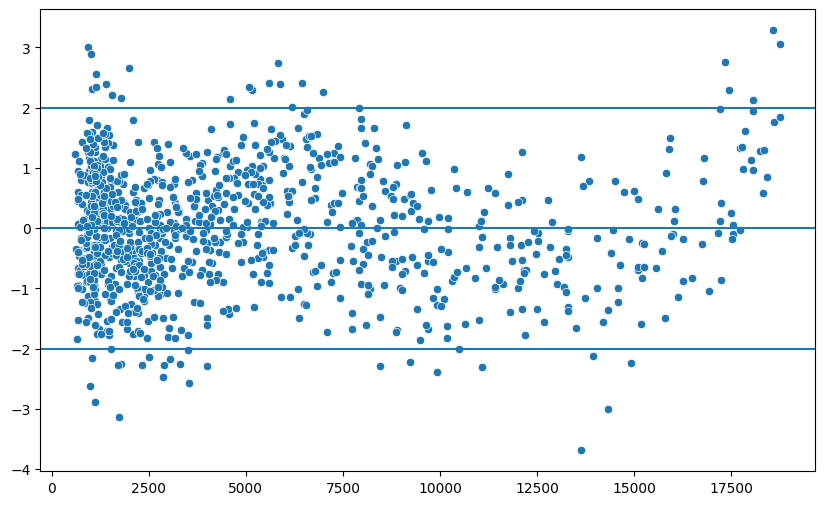

In [167]:
# Verificar linearidade dos resíduos: Valores entre -2 e +2 (escala padrão)
# Verificar a homocedasticidade: Valores em torno da reta sem nenhuma tendencia ou formato
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

Text(0, 0.5, 'Resíduos na escala padrão')

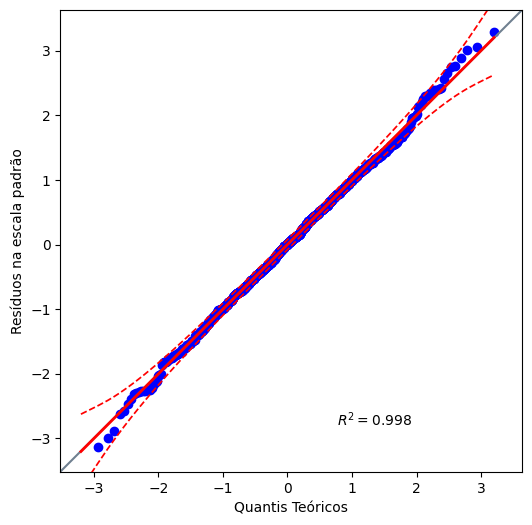

In [168]:
# Checar se resíduos seguem uma distribuição normal
# QQ-Plot
plt.figure(figsize=(10,6))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')

In [169]:
# Teste de normalidade - Shapiro-Wilk
stats_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estat. Teste: {stats_shapiro} e P-value: {p_value_shapiro}') 

Estat. Teste: 0.9986951372205322 e P-value: 0.6852797159659514


In [170]:
# Teste de normalidade - Kolmogorov-Smirnov
stats_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estat. Teste: {stats_ks} e P-value: {p_value_ks}') 

Estat. Teste: 0.48237446499530856 e P-value: 1.2202460106524514e-214


In [171]:
# Teste de normalidade - Lilliefors
stats_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estat. Teste: {stats_ll} e P-value: {p_value_ll}') 

Estat. Teste: 0.013637346894986191 e P-value: 0.9566270022044506


In [ ]:
# Predição Individual
input_features = {
    'tempo_na_empresa': 70,
    'nivel_na_empresa': 10
}

pred_df = pd.DataFrame(input_features, index=[1])

In [ ]:
# Predição
model_poly.predict(pred_df)

array([4559.15455734])

In [ ]:
# Salvar modelo
joblib.dump(model_poly, './modelo_salario.pkl')

['./modelo_salario.pkl']